# 04-notebook-rough-draft for final project

I am working on the Kaggle Grupo Bimbo competition dataset for this project. 
Link to Grupo Bimbo Kaggle competition: [Kaggle-GrupoBimbo](https://www.kaggle.com/c/grupo-bimbo-inventory-demand)

In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble
#QUESTION - what is diff bw random forest classifier and rf regressor?

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

![](../assets/images/workflow/data-science-workflow-01.png)

## Part 1. Identify the Problem



**Problem**: Given various sales/client/product data, we want to predict demand for each product at each store on a weekly basis. Per the train dataset, the average demand for a product at a store per week is 7.2 units. However, this does not factor in cases in which store managers under-predict demand for a product which we can see when returns=0 for that week. There are 74,180,464 records in the train data, of which 71,636,003 records have returns=0 or approx 96%. This generally means that managers probably often under predict product demand (unless that are exact on the money, which seems unlikely). 

**Goals**: The goal is to predict demand for each product at each store on a weekly basis while avoiding under-predicting demand.

**Hypothesis**: As stated previously, the average product demand at a store per week is 7.2 units per the train data. However, given the likelihood of managers underpredicint product demand, I hypothesize a good model should return a number higher than 7.2 units to more accurately predict demand.

![](../assets/images/workflow/data-science-workflow-02.png)

## Part 2. Acquire the Data

Kaggle has provided five files for this dataset:  
_train.csv_: Use for building a model (contains target variable "Demanda_uni_equil")  
_test.csv_: Use for submission file (fill in for target variable "Demanda_uni_equil")
_cliente_tabla.csv_: Contains client names (can be joined with train/test on Cliente_ID)
_producto_tabla.csv_: Contains product names (can be join with train/test on Producto_ID)
_town_state.csv_: Contains town and state (can be join with train/test on Agencia_ID)


**Notes**: I will further split _train.csv_ to generate my own cross validation set. However, I will use all of _train.csv_ to train my final model since Kaggle has already supplied a test dataset. Additionally, I am only using a random 10% of the train data given to me for EDA and model development. Using the entire train dataset proved to be too time consuming for the quick iternations needed for initial modeling building and EDA efforts. I plan to use 100% of the train dataset once I build a model I'm comfortable with. I may have to explore using EC2 for this effort.

In [2]:
# Load train data
# Given size of training data, I chose to use only 10% for speed reasons
# QUESTION - how can i randomize with python? i used sql to create the random sample below.
df_train = pd.read_csv("train_random10percent.csv")

# Check head
df_train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1112,1,1210,4619860,1150,2,27.92,0,0.0,2
1,3,1112,1,1210,4619860,1160,1,18.86,0,0.0,1
2,3,1112,1,1210,4619860,1182,4,55.76,0,0.0,4
3,3,1112,1,1210,4683304,1109,2,30.02,0,0.0,2
4,3,1112,1,1210,4683304,1125,7,67.20,0,0.0,7


In [3]:
# Load test data
df_test = pd.read_csv("test.csv")

# Check head. I noticed that I will have to drop certain columns so that test and train sets have the same features. 
df_test.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [4]:
#given that i cannot use a significant amount of variables in train data, i created additoinal features using the mean
#i grouped on product id since i will ultimately be predicting demand for each product

df_train_mean = df_train.groupby('Producto_ID').mean().add_suffix('_mean').reset_index()
df_train_mean.head()

,Producto_ID,Semana_mean,Agencia_ID_mean,Canal_ID_mean,Ruta_SAK_mean,Cliente_ID_mean,Venta_uni_hoy_mean,Venta_hoy_mean,Dev_uni_proxima_mean,Dev_proxima_mean,Demanda_uni_equil_mean
0,41,6.500000,2257.714286,7.000000,3476.428571,9.927571e+05,261.857143,4733.798571,6.428571,116.550000,261.857143
1,53,7.000000,1868.818182,4.000000,7614.636364,2.606382e+06,219.909091,3144.700000,0.000000,0.000000,219.909091
2,72,6.139906,2569.569063,1.085722,2370.468701,1.505971e+06,4.918930,18.179211,0.083738,0.307245,4.869604
3,73,6.032710,2207.965045,1.183846,1291.151503,1.302741e+06,3.213304,68.875936,0.077698,1.659034,3.140966
4,100,5.928571,1827.500000,7.428571,3385.714286,2.014600e+06,10.642857,190.905714,9.642857,209.871429,10.642857


In [5]:
#from above, adding 2 additional features, the average sales units and the average demand
df_train2 = df_train.merge(df_train_mean[['Producto_ID','Venta_uni_hoy_mean', 'Demanda_uni_equil_mean']],how='inner',on='Producto_ID')
df_train2.sample(5)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Venta_uni_hoy_mean,Demanda_uni_equil_mean
6683451,9,4040,1,1107,425736,43118,1,9.91,0,0.0,1,4.430301,4.371233
6617790,9,1471,1,1140,909746,43207,10,30.20,0,0.0,10,14.659612,14.605897
3116578,9,1631,1,1042,990227,2233,11,219.34,0,0.0,11,5.679594,5.626612
4748965,6,1147,4,6612,4410563,4245,3,35.76,0,0.0,3,4.101097,3.974700
2259099,6,3213,1,1435,48194,1242,7,53.48,0,0.0,7,5.096787,5.057117


In [6]:
# Adding features to the test set in order to match train set
df_test2 = df_test.merge(df_train_mean[['Producto_ID','Venta_uni_hoy_mean', 'Demanda_uni_equil_mean']],how='left',on='Producto_ID')
df_test2.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy_mean,Demanda_uni_equil_mean
0,0,11,4037,1,2209,4639078,35305,9.171683,9.132431
1,1,11,2237,1,1226,4705135,1238,3.217857,3.161574
2,2,10,2045,1,2831,4549769,32940,4.042903,4.018765
3,3,11,1227,1,4448,4717855,43066,2.499306,2.439875
4,4,11,1219,1,1130,966351,1277,1.500000,1.500000


![](../assets/images/workflow/data-science-workflow-03-05.png)

## Part 3. Parse, Mine, and Refine the data

Perform exploratory data analysis and verify the quality of the data.

### Check columns and counts to drop any non-generic or near-empty columns

In [7]:
# Check columns
print "train dataset columns:"
print df_train2.columns.values
print 
print "test dataset columns:"
print df_test2.columns.values

train dataset columns:
['Semana' 'Agencia_ID' 'Canal_ID' 'Ruta_SAK' 'Cliente_ID' 'Producto_ID'
 'Venta_uni_hoy' 'Venta_hoy' 'Dev_uni_proxima' 'Dev_proxima'
 'Demanda_uni_equil' 'Venta_uni_hoy_mean' 'Demanda_uni_equil_mean']

test dataset columns:
['id' 'Semana' 'Agencia_ID' 'Canal_ID' 'Ruta_SAK' 'Cliente_ID'
 'Producto_ID' 'Venta_uni_hoy_mean' 'Demanda_uni_equil_mean']


In [8]:
# Check counts
print "train dataset counts:"
print df_train2.count()
print
print "test dataset counts:"
print df_test2.count()

train dataset counts:
Semana                    7413317
Agencia_ID                7413317
Canal_ID                  7413317
Ruta_SAK                  7413317
Cliente_ID                7413317
Producto_ID               7413317
Venta_uni_hoy             7413317
Venta_hoy                 7413317
Dev_uni_proxima           7413317
Dev_proxima               7413317
Demanda_uni_equil         7413317
Venta_uni_hoy_mean        7413317
Demanda_uni_equil_mean    7413317
dtype: int64

test dataset counts:
id                        6999251
Semana                    6999251
Agencia_ID                6999251
Canal_ID                  6999251
Ruta_SAK                  6999251
Cliente_ID                6999251
Producto_ID               6999251
Venta_uni_hoy_mean        6955480
Demanda_uni_equil_mean    6955480
dtype: int64


### Check for missing values and drop or impute

In [9]:
# Check counts for missing values in each column
print "train dataset missing values:"
print df_train2.isnull().sum()
print
print "test dataset missing values:"
print df_test2.isnull().sum()

train dataset missing values:
Semana                    0
Agencia_ID                0
Canal_ID                  0
Ruta_SAK                  0
Cliente_ID                0
Producto_ID               0
Venta_uni_hoy             0
Venta_hoy                 0
Dev_uni_proxima           0
Dev_proxima               0
Demanda_uni_equil         0
Venta_uni_hoy_mean        0
Demanda_uni_equil_mean    0
dtype: int64

test dataset missing values:
id                            0
Semana                        0
Agencia_ID                    0
Canal_ID                      0
Ruta_SAK                      0
Cliente_ID                    0
Producto_ID                   0
Venta_uni_hoy_mean        43771
Demanda_uni_equil_mean    43771
dtype: int64


### Wrangle the data to address any issues from above checks

In [10]:
# Drop columns not included in test dataset
df_train2 = df_train2.drop(['Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima'], axis=1)

# Check data
df_train2.head()


,Semana,Cliente_ID,Producto_ID,Demanda_uni_equil,Venta_uni_hoy_mean,Demanda_uni_equil_mean
0,3,4619860,1150,2,6.242652,6.191044
1,3,1723873,1150,1,6.242652,6.191044
2,3,4314785,1150,1,6.242652,6.191044
3,3,66252,1150,3,6.242652,6.191044
4,3,210290,1150,17,6.242652,6.191044


In [11]:
# Drop blank values in test set and replace with mean

# Replace missing values for venta_uni_hoy_mean using mean
df_test2.loc[(df_test2['Venta_uni_hoy_mean'].isnull()), 'Venta_uni_hoy_mean'] = df_test2['Venta_uni_hoy_mean'].dropna().mean()

# Replace missing values for demand using mean
df_test2.loc[(df_test2['Demanda_uni_equil_mean'].isnull()), 'Demanda_uni_equil_mean'] = df_test2['Demanda_uni_equil_mean'].dropna().mean()

print "test dataset missing values:"
print df_test2.isnull().sum()

test dataset missing values:
id                        0
Semana                    0
Cliente_ID                0
Producto_ID               0
Venta_uni_hoy_mean        0
Demanda_uni_equil_mean    0
dtype: int64


### Perform exploratory data analysis

In [12]:
# Get summary statistics for data
df_train2.describe()

,Semana,Cliente_ID,Producto_ID,Demanda_uni_equil,Venta_uni_hoy_mean,Demanda_uni_equil_mean
count,7.413317e+06,7.413317e+06,7.413317e+06,7.413317e+06,7.413317e+06,7.413317e+06
mean,5.950245e+00,1.802524e+06,2.083868e+04,7.218393e+00,7.304598e+00,7.218393e+00
std,2.013394e+00,2.362439e+06,1.866494e+04,2.164558e+01,1.192780e+01,1.176922e+01
min,3.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,3.567670e+05,1.242000e+03,2.000000e+00,3.287170e+00,3.235731e+00
50%,6.000000e+00,1.193440e+06,3.054900e+04,3.000000e+00,5.321605e+00,5.306513e+00
75%,8.000000e+00,2.371366e+06,3.742700e+04,6.000000e+00,7.343644e+00,7.316136e+00
max,9.000000e+00,2.015152e+09,4.999700e+04,5.000000e+03,3.000000e+03,3.000000e+03


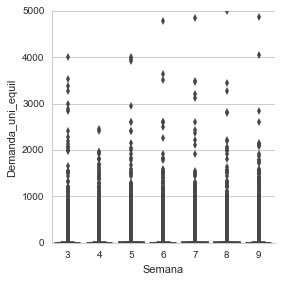

In [13]:
#Show box plot of demand by week
sns.factorplot(
    x='Semana',
    y='Demanda_uni_equil',
    data=df_train2,
    kind='box')

### Check and convert all data types to numerical

In [14]:
# Check data types
df_train.dtypes

#these are all numerical but are not continuous values and therefore don't have relative significant to one another, except for week
#however, creating dummy variables for all these is too memory intensive. as such, might have to explore using a random forest model
#in addition to the linear regression model

Semana                 int64
Agencia_ID             int64
Canal_ID               int64
Ruta_SAK               int64
Cliente_ID             int64
Producto_ID            int64
Venta_uni_hoy          int64
Venta_hoy            float64
Dev_uni_proxima        int64
Dev_proxima          float64
Demanda_uni_equil      int64
dtype: object

![](../assets/images/workflow/data-science-workflow-06.png)

## Part 4. Build a Model

Create a cross validation split, select and build a model, evaluate the model, and refine the model

### Create cross validation sets

In [15]:
#create cross validation sets

#set target variable name
target = 'Demanda_uni_equil'

#set X and y
X = df_train2.drop([target], axis=1)
y = df_train2[target]

# create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size= .4) 

#QUESTION - do i have to cross validate when using kaggle data? prob not.

### Build a model

In [16]:
#create linear regression object
#lm = linear_model.LinearRegression()

#create random forest object
#rf = ensemble.RandomForestClassifier(n_estimators=10) - did not work due to memory errors during fitting
rf = ensemble.RandomForestRegressor(n_estimators=10)

In [17]:
#train the model using the training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Evaluate the model

In [19]:
# Check score on test set
print "Score: %0.3f" % rf.score(X_test,y_test)

Score: 0.260


![](../assets/images/workflow/data-science-workflow-07.png)

## Part 5: Present the Results

Generate summary of findings and kaggle submission file.

NOTE: For the purposes of generating summary narratives and kaggle submission, we can train the model on the entire training data provided in _train.csv_.

### Load Kaggle training data and use entire data to train tuned model

In [20]:
# Set target variable name
target = 'Demanda_uni_equil'

# Set X_train and y_train
X_train = df_train2.drop([target], axis=1)
y_train = df_train2[target]

In [23]:
# Build tuned model
#create linear regression object
#lm = linear_model.LinearRegression()

#create random forest object
rf = ensemble.RandomForestRegressor(n_estimators=10)

#train the model using the training data
#lm.fit(X_train,y_train)
rf.fit(X_train,y_train)

# Score tuned model
print "Score: %0.3f" % rf.score(X_train, y_train)

Score: 0.852


### Load Kaggle test data, make predictions using model, and generate submission file

In [24]:
#create data frame for submission
df_sub = df_test2[['id']]

df_test2 = df_test2.drop('id', axis=1)

#predict using tuned model
df_sub['Demanda_uni_equil'] = lm.predict(df_test2)

df_sub.describe()

,id,Demanda_uni_equil
count,6.999251e+06,6.999251e+06
mean,3.499625e+06,7.226255e+00
std,2.020510e+06,1.171634e+01
min,0.000000e+00,-3.174964e+02
25%,1.749812e+06,3.271562e+00
50%,3.499625e+06,5.288983e+00
75%,5.249438e+06,7.380220e+00
max,6.999250e+06,1.580665e+03


In [25]:
d = df_sub['Demanda_uni_equil']
d[d<0] = 0
df_sub.describe()


C:\Users\rwoodruff\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,id,Demanda_uni_equil
count,6.999251e+06,6.999251e+06
mean,3.499625e+06,7.226666e+00
std,2.020510e+06,1.171064e+01
min,0.000000e+00,0.000000e+00
25%,1.749812e+06,3.271562e+00
50%,3.499625e+06,5.288983e+00
75%,5.249438e+06,7.380220e+00
max,6.999250e+06,1.580665e+03


In [26]:
# Write submission file
df_sub.to_csv("mysubmission4.csv", index=False)

**Kaggle score** : 
using linear regression 0.75682
using random forest: 0.76720


In [ ]:
#notes
#want to try to use a classifier like random forest or logistic regression
#do somethign wtih time series to check for seasonality or general trending?